# Simulate XMM EPIC images with double King profiles

Parameters taken from Jukka Nevalainen for Abell 1795

Author: Ivan Valtchanov, ESAC, Oct 2018

In [1]:
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u

import matplotlib.pylab as plt

import os
import numpy as np

import aplpy

from photutils import SkyCircularAperture, SkyCircularAnnulus, aperture_photometry

home = os.path.expanduser('~')

/Users/ivaltcha/miniconda3/envs/py37/lib/python3.7/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  obj_type='module')


In [2]:
def king2betaX(xin,yin,s0_cool,s0_amb,r_cool,r_core,beta_cool,beta_amb,rmask=None):
    #
    # rlimit,r_cool,r_amb are in arcmin
    # s0_cool and s0_amb are the normalisation in cts/s/arcmin^2
    # following Nevalainen
    rx = np.sqrt(xin*xin + yin*yin)
    r2_cool = np.power((rx/r_cool),2)
    r2_amb = np.power((rx/r_core),2)
    #
    bx1 = 0.5 - 3*beta_cool
    bx2 = 0.5 - 3.0*beta_amb
    scool = s0_cool*np.power((1.0 + r2_cool),bx1)
    samb = s0_amb*np.power((1.0 + r2_amb),bx2)
    #
    total = scool + samb
    return total


To simulate the cluster for a particulat EPIC instrument we need the detector mask. To create the detector mask you can use `XMM-SAS`, to create an exposure image first and then the detector mask.

In [118]:
#wdir = f'{home}/Tmp/XMM_data/0097820101/pps'
#image = f'{wdir}/P0097820101PNS005IMAGE_3000.FTZ'
#expo = f'{wdir}/P0097820101PNS005EXPMAP3000.FTZ'
wdir = '{}/XMM/Clusters/a1795/0097820101/xmmsas_20180620_1732-17.0.0'.format(home)
#
# instrument
#
instrument = "pn"
#instrument = "mos1"
#instrument = "mos2"
image = '{}/{}_image_500_7000.fits'.format(wdir,instrument)
detmask = '{}/{}_detmask_500_7000.fits'.format(wdir,instrument)
hdu1 = fits.open(image)
wcs = WCS(hdu1[0].header)
center = SkyCoord(207.2208333,26.59027778,unit=(u.deg,u.deg),frame='icrs')
#center = SkyCoord(hdu1[0].header['RA_OBJ'],hdu1[0].header['DEC_OBJ'],unit=(u.deg,u.deg),frame='icrs')
hdu2 = fits.open(detmask)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [119]:
nx,ny = hdu1[0].data.shape
y, x = np.mgrid[0:ny, 0:nx]
xy = wcs.wcs_world2pix(center.ra.value,center.dec.value,1)
y = y - xy[1]
x = x - xy[0]

In [120]:
# now evaluate the profile on the grid
#
arcmin2pix = wcs.pixel_scale_matrix[1,1]*60.0
rcool = 0.65 # arcmin
rcore = 2.45 # arcmin
rcool_pix = 0.65/arcmin2pix # pixels
rcore_pix = 2.45/arcmin2pix # pixels
betac = 0.72
betaa = 0.72
s0c = 6.3 # cts/s/arcmin^2
s0a = 0.83 # cts/s/arcmin^2
s0c_pix = 6.3/(arcmin2pix*arcmin2pix) # cts/s/pix
s0a_pix = 0.83/(arcmin2pix*arcmin2pix) # cts/s/pix
#
profile = king2betaX(x,y,s0c_pix,s0a_pix,rcool_pix,rcore_pix,betac,betaa)
#

In [121]:
#
# now multiply by the exposure time normalised to 1
#
# first save without detector mask
hdu1[0].data = profile
outfile1 = '{}/{}_500_7000_simulated_nomask.fits'.format(wdir,instrument)
hdu1.writeto(outfile1,overwrite=True)
# now with the detmask
profile2 = profile*hdu2['MASK'].data
hdu1[0].data = profile2
outfile2 = '{}/{}_500_7000_simulated.fits'.format(wdir,instrument)
hdu1.writeto(outfile2,overwrite=True)

In [122]:
#
# now measur the aperture flux in the ideal image
#
aperture = SkyCircularAperture(center, r=4. * u.arcmin)
aper_pix = aperture.to_pixel(wcs)
photo1 = aperture_photometry(profile, aperture,wcs=wcs)
aper_area = aperture.to_pixel(wcs).area()
ap_flux1 = photo1['aperture_sum'][0]
print ("Total flux in aperture, simulated ideal image: {}".format(ap_flux1))

Total flux in aperture, simulated ideal image: 1275085.0422431282


In [123]:
#
# image with detector mask
#
photo2 = aperture_photometry(profile2, aperture,wcs=wcs)
ap_flux2 = photo2['aperture_sum'][0]
print ("Total flux in aperture, simulated image with {} mask: {}".format(instrument,ap_flux2))

Total flux in aperture, simulated image with mos2 mask: 1231826.758683786


In [124]:
#
# the detector mask
#
photo3 = aperture_photometry(hdu2['MASK'].data, aperture,wcs=wcs)
ap_flux3 = photo3['aperture_sum'][0]
print ("Total flux in aperture, {} detector mask: {}".format(instrument,ap_flux3))

Total flux in aperture, mos2 detector mask: 11138.080595564155


In [125]:
print ("{} Masked/non-masked fraction (%): {:.1f}".format(instrument,100*(1-ap_flux3/aper_area)))
print ("{} Masked/non-masked image flux(%): {:.1f}".format(instrument,100*(1-ap_flux2/ap_flux1)))

mos2 Masked/non-masked fraction (%): 1.5
mos2 Masked/non-masked image flux(%): 3.4


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -1.000e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.110e+00 [aplpy.core]


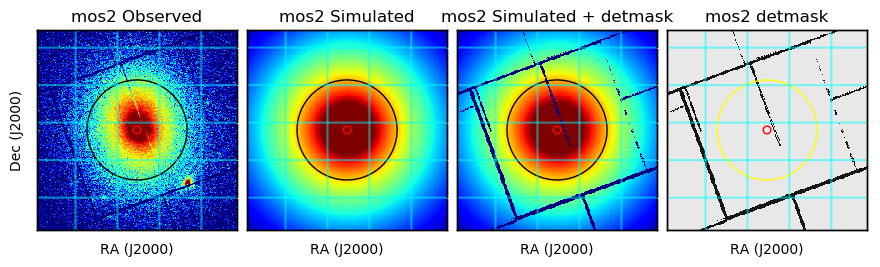

In [126]:
fig = plt.figure(figsize=(10,10),dpi=100)
f0 = aplpy.FITSFigure(image, figure=fig, subplot=[0.1,0.1,0.2,0.2])
f0.show_colorscale(vmin=1,vmax=100,stretch='log')
f0.set_title('{} Observed'.format(instrument))
f0.add_grid()
f0.grid.set_color('cyan')
f0.grid.set_alpha(0.5)
f0.show_circles(aperture.positions.ra.value,aperture.positions.dec.value,\
                    aperture.r.value/60.0,edgecolor='black')
f0.recenter(aperture.positions.ra.value,aperture.positions.dec.value,radius=8.0/60.0)
f0.show_markers(aperture.positions.ra.value,aperture.positions.dec.value)
f0.tick_labels.set_xformat('hh:mm:ss.s')
f0.tick_labels.set_yformat('dd:mm:ss')
f0.hide_ytick_labels()
f0.hide_xtick_labels()
#
f1 = aplpy.FITSFigure(outfile1, figure=fig, subplot=[0.31,0.1,0.2,0.2])
f1.show_colorscale(vmin=1,vmax=100,stretch='log')
f1.set_title('{} Simulated'.format(instrument))
f1.add_grid()
f1.grid.set_color('cyan')
f1.grid.set_alpha(0.5)
f1.show_circles(aperture.positions.ra.value,aperture.positions.dec.value,\
                    aperture.r.value/60.0,edgecolor='black')
f1.recenter(aperture.positions.ra.value,aperture.positions.dec.value,radius=8.0/60.0)
f1.show_markers(aperture.positions.ra.value,aperture.positions.dec.value)
f1.tick_labels.set_xformat('hh:mm:ss.s')
f1.tick_labels.set_yformat('dd:mm:ss')
f1.axis_labels.hide_y()
f1.hide_ytick_labels()
f1.hide_xtick_labels()
#
f2 = aplpy.FITSFigure(outfile2, figure=fig, subplot=[0.52,0.1,0.2,0.2])
f2.show_colorscale(vmin=1,vmax=100,stretch='log')
f2.set_title('{} Simulated + detmask'.format(instrument))
f2.add_grid()
f2.grid.set_color('cyan')
f2.grid.set_alpha(0.5)
f2.show_circles(aperture.positions.ra.value,aperture.positions.dec.value,\
                    aperture.r.value/60.0,edgecolor='black')
f2.recenter(aperture.positions.ra.value,aperture.positions.dec.value,radius=8.0/60.0)
f2.show_markers(aperture.positions.ra.value,aperture.positions.dec.value)
f2.tick_labels.set_xformat('hh:mm:ss.s')
f2.tick_labels.set_yformat('dd:mm:ss')
f2.axis_labels.hide_y()
f2.hide_xtick_labels()
f2.hide_ytick_labels()
#
f3 = aplpy.FITSFigure(detmask, hdu=1,figure=fig, subplot=[0.73,0.1,0.2,0.2])
f3.show_grayscale()
f3.set_title('{} detmask'.format(instrument))
f3.add_grid()
f3.grid.set_color('cyan')
f3.grid.set_alpha(0.5)
f3.show_circles(aperture.positions.ra.value,aperture.positions.dec.value,\
                    aperture.r.value/60.0,edgecolor='yellow')
f3.recenter(aperture.positions.ra.value,aperture.positions.dec.value,radius=8.0/60.0)
f3.show_markers(aperture.positions.ra.value,aperture.positions.dec.value)
f3.tick_labels.set_xformat('hh:mm:ss.s')
f3.tick_labels.set_yformat('dd:mm:ss')
f3.axis_labels.hide_y()
f3.hide_xtick_labels()
f3.hide_ytick_labels()
#
